# FEAUTURE ENGINEERING & DATA PRE-PROCESSIN

In [1]:
# Importing Libraries
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import  LocalOutlierFactor
from sklearn.preprocessing import  MinMaxScaler, LabelEncoder,StandardScaler, RobustScaler


In [2]:
# Pandas View Options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x:'%.3f' % x)
pd.set_option('display.width', 500)

In [3]:
## Load Datasets
def load_dataset(data_url='data/titanic.csv'):
    data =pd.read_csv(data_url)
    return data

In [4]:
df = load_dataset()

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


## OUTLIERS
### Lecture 1
1. Determine threshold
2. Find the outliers
3. Quickly check if any outlier exists

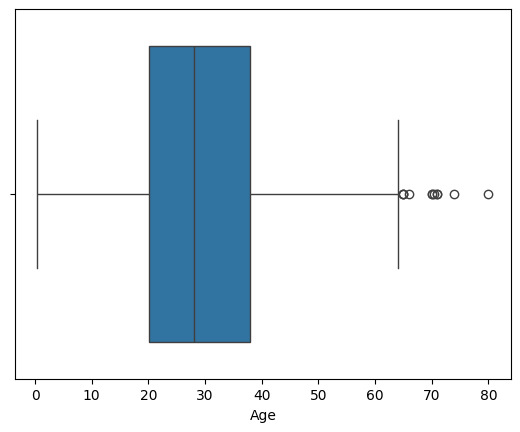

In [6]:
# Outliers with boxplot
sns.boxplot(x=df['Age'])
plt.show()

In [7]:
### Detcting Outliers
## Finding Thresholds
## First we need to find quartiles so we can calculate IQR
q1 = df['Age'].quantile(0.25)
print(f'25th percentile = {q1}')
q3 = df['Age'].quantile(0.75)
print(f'75th percentile = {q3}')

25th percentile = 20.125
75th percentile = 38.0


In [8]:
# Finding iqr and calculating lower and upper limit 
iqr = q3-q1 
low_limit = q1 - 1.5*iqr
up_limit = q3 + 1.5*iqr
print(f'lower limit = {low_limit}\nupper limit = {up_limit} ')

lower limit = -6.6875
upper limit = 64.8125 


In [9]:
#Finding outliers with the limits
# Because low limit is below zero there is no data lower than the low limit
df.query('Age > @up_limit | Age < @low_limit')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.000,0,0,C.A. 24579,10.500,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.000,0,1,113509,61.979,B30,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.000,0,0,PC 17754,34.654,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.500,0,0,370369,7.750,NaN,Q
280,281,0,3,"Duane, Mr. Frank",male,65.000,0,0,336439,7.750,NaN,Q
456,457,0,1,"Millet, Mr. Francis Davis",male,65.000,0,0,13509,26.550,E38,S
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.000,0,0,PC 17609,49.504,NaN,C
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.000,0,0,27042,30.000,A23,S
672,673,0,2,"Mitchell, Mr. Henry Michael",male,70.000,0,0,C.A. 24580,10.500,NaN,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.000,1,1,WE/P 5735,71.000,B22,S


In [10]:
# Getting the index of outliers
df.query('Age > @up_limit | Age < @low_limit').index

Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

In [11]:
# For finding are there any outliers True or False
# Are there any data lower than the low limit or upper than up limit
df.query('Age > @up_limit | Age < @low_limit').any(axis=None)

True

In [12]:
# Are there any data lower than the low limit
df.query('Age < @low_limit').any(axis=None)

False

### Lecture 2
1. Creating functions for outliers
- Feature Engineering , Data Pre-processing should be on script level
- It should run on os level and complete all the data pre processing
- So we should do everything programmaticly with functions on script level


In [13]:
# Find outlier thresholds
# q1 and q3 values could change (5-95 or 1-99)
# The instructor prefers 5-95 but in lit. it is 25-75
def outlier_thresholds(df, col_name, q1 = 0.25, q3 = 0.75 ):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * interquantile_range
    lower_limit = quartile1- 1.5 * interquantile_range
    return lower_limit,upper_limit

In [14]:
outlier_thresholds(df,'Age')


(-6.6875, 64.8125)

In [15]:
outlier_thresholds(df,'Fare')

(-26.724, 65.6344)

In [16]:
low, up = outlier_thresholds(df,'Fare')
df.query('Fare > @up | Fare < @low')['Fare'].describe()

count   116.000
mean    128.292
std      84.637
min      66.600
25%      78.190
50%      90.000
75%     147.778
max     512.329
Name: Fare, dtype: float64

In [17]:
def check_outlier(df, col_name):
    low_limit, up_limit = outlier_thresholds(df,col_name)
    return df[(df[col_name] > up_limit )| (df[col_name] < low_limit)].any(axis=None)


In [18]:
check_outlier(df, 'Age')

True

In [19]:
check_outlier(df, 'Fare')

True

### Lecture 3
- We need to check_outlier for every variable how can we do it programmaticly
- How can we get numerical variables, categorical variables etc.

In [21]:
# Categoric -> Sex
# Numerical -> Fare
# There are some variables in this dataset that is numerical but actually categorical
# seems like numerical categorical variables -> Pclass(1,2,3), Survived(0,1)
# SibSp(Number of siblings) could be assessed as categorical, open to interepretation, not final
# Another type is categorical but not carrying information, has so many classes this one called cardinal variables
# seems like categorical but cardinal variables ->Name, Ticket, cabin- no measurement value- not categoric because has as many category classes as sample numbers
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [39]:
# With this function we can get variable types mentioned above
# Categoric
# Numerical
# seems like numerical categorical variables
# seems like categorical but cardinal variables
def grab_col_names(df, categoric_threshold = 10, cardinal_threshold = 20):
    """
    Gives the actual categorical, actual numerical and seems categorical but cardinal variable names
    Note: Categoric variables includes seems like numerical categorical variables

    Parameters
    -------
    df: dataframe- Dataframe to get variable names    
    categoric_threshold: int, optional - numeric but categorical variables threshold value
    cardinal_threshold: int, optional - categoric but cardinal variables threshold value
    Note: Thresholds can change according to dataset
    Returns
    -------
    categoric_cols:list -List of cat variables
    num_cols:list - List of numerical variables
    cat_but_car: list - List of cardinal variables


    """
    # Getting the all look like categorical variables
    categorical_cols = [col for col in df.columns if df[col].dtypes == "O"]
    # Getting the seems like numerical but categorical variables
    # If class number (unique value) lower than categorical threshold it is a categorical variable not numerical
    num_but_cat = [col for col in df.columns if df[col].nunique() < categoric_threshold and df[col].dtypes != "O"]
    # Getting the seems like categorical but cardinal variables
    # If class number (unique value) bigger than cardinal threshold it is a cardinal variable not categorical
    cat_but_car = [col for col in df.columns if df[col].nunique() > cardinal_threshold and df[col].dtypes == "O"]
    # Getting the actual categorical variables added the numerical categorical and substract cardinal categorical variables
    categorical_cols = categorical_cols + num_but_cat
    categorical_cols = [col for col in categorical_cols if col not in cat_but_car]
    
    # Getting the all look like numerical variables
    num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    #Getting the actual numerical variables by substracting numeric categorical variables
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations:{df.shape[0]}")
    print(f"Variables:{df.shape[1]}")
    print(f"categorical columns:{len(categorical_cols)}")
    print(f"numerical columns:{len(num_cols)}")
    print(f"cardinal columns:{len(cat_but_car)}")
    print(f"numeric but categorical variables:{len(num_but_cat)}")
    # num_but_cat is in categorical variables
    return categorical_cols, num_cols, cat_but_car



In [40]:
categorical_cols, num_cols, cat_but_car = grab_col_names(df)

Observations:891
Variables:12
categorical columns:6
numerical columns:3
cardinal columns:3
numeric but categorical variables:4


In [38]:
# All  numerical categorical variables catched
# There are two open to interpreation var.:'SibSp'  'Parch'
# We can change that by changing the thresholds but with this thresholds they are categorical not numerical
categorical_cols

['Sex', 'Embarked', 'Survived', 'Pclass', 'SibSp', 'Parch']

In [ ]:
# We classisifed variables programmaticly 
# Sometimes we cant understand this in first look or there are so many variables
# Making this with a function is so much easier

In [41]:
# Id and dates are the exception
# Not control this in the function because it will reduce readability of the function
num_cols

['PassengerId', 'Age', 'Fare']

In [44]:
# Redefining num_col here
num_cols = [col for col in num_cols if col not in "PassengerId"]
print(num_cols)

['Age', 'Fare']


In [ ]:
# cardinal variables are non functional we dont really need it

In [45]:
# Find out if there is outlier in numerical columns
for col in num_cols:
    print(col, check_outlier(df,col))

Age True
Fare True


In [46]:
# Loading big dataset
df_big =load_dataset('data/application_train.csv')

In [47]:
# There can be binary encoded var. -> Categorical var
# We find all numerical and categorical var. 
categorical_cols, num_cols, cat_but_car = grab_col_names(df_big)

Observations:307511
Variables:122
categorical columns:54
numerical columns:67
cardinal columns:1
numeric but categorical variables:39


In [49]:
# Excluding ID from num cols
num_cols = [col for col in num_cols if col not in "SK_ID_CURR"]


In [50]:
# Find out if there is outlier in numerical columns
# Dont forget q1 and q3 are 0.25 snd 0.75
# Because of that most of them has outliers
for col in num_cols:
    print(col, check_outlier(df_big,col))

CNT_CHILDREN True
AMT_INCOME_TOTAL True
AMT_CREDIT True
AMT_ANNUITY True
AMT_GOODS_PRICE True
REGION_POPULATION_RELATIVE True
DAYS_BIRTH False
DAYS_EMPLOYED True
DAYS_REGISTRATION True
DAYS_ID_PUBLISH False
OWN_CAR_AGE True
CNT_FAM_MEMBERS True
HOUR_APPR_PROCESS_START True
EXT_SOURCE_1 False
EXT_SOURCE_2 False
EXT_SOURCE_3 False
APARTMENTS_AVG True
BASEMENTAREA_AVG True
YEARS_BEGINEXPLUATATION_AVG True
YEARS_BUILD_AVG True
COMMONAREA_AVG True
ELEVATORS_AVG True
ENTRANCES_AVG True
FLOORSMAX_AVG True
FLOORSMIN_AVG True
LANDAREA_AVG True
LIVINGAPARTMENTS_AVG True
LIVINGAREA_AVG True
NONLIVINGAPARTMENTS_AVG True
NONLIVINGAREA_AVG True
APARTMENTS_MODE True
BASEMENTAREA_MODE True
YEARS_BEGINEXPLUATATION_MODE True
YEARS_BUILD_MODE True
COMMONAREA_MODE True
ELEVATORS_MODE True
ENTRANCES_MODE True
FLOORSMAX_MODE True
FLOORSMIN_MODE True
LANDAREA_MODE True
LIVINGAPARTMENTS_MODE True
LIVINGAREA_MODE True
NONLIVINGAPARTMENTS_MODE True
NONLIVINGAREA_MODE True
APARTMENTS_MEDI True
BASEMENTAREA_MEDI 